# Thermal responses to pulse-like forcing changes

Comparison between two-layer and three-layer models

In [ ]:
%cd ..

In [2]:
import numpy as np
import pandas as pd
from mce.core import ScenarioBase
from mce.core.driver import DriverBase
from mce.util.plot_base import PlotBase

In [3]:
myplt = PlotBase(palette='ipcc_wg1')

## Custom drivers

In [4]:
class Driver(DriverBase):
    def __init__(self, **kw):
        super().__init__(**kw)
    
        seconds_per_year = 3.15569e7
        earth_area = 5.10e14 # m^2
        self.ntoa2joule = seconds_per_year * earth_area * 1e-21

    def forcing_response(self, time, **kw):
        """To be overridden
        """
        tauj = self.climate.parms.tauj
        q = 0.
        tlev = np.zeros((len(time), len(tauj)))

        return q, tlev

    def run(self, time, **kw):
        """Perform time integration using IrmBase methods
        instead of the generic Driver method.
        """
        pebm = self.save['climate'] # include lambk, xik, akj
        # Ocean heat uptake efficacy can be applied
        eff = self.climate.parms.eff

        q, tlev = self.forcing_response(time, **kw)

        tas = tlev[:, 0]
        rtnt = q - pebm['lambk'][0] * tas
        thc = tlev * pebm['xik']

        if eff != 1.:
            # Adjustment for ocean heat uptake efficacy
            rtnt -= (eff - 1.) * (pebm['lambk'][-1] / eff) * (tlev[:, -2] - tlev[:, -1])
            thc[:, -1] /= eff

        return pd.DataFrame({
            'rtnt': rtnt,
            'tas': tas,
            'thc': thc.sum(axis=1) * self.ntoa2joule,
        }, index=time)


In [5]:
class Driver4x(Driver):
    """Driver for thermal response to step forcing
    """
    def forcing_response(self, time, **kw):
        # Use 4xCO2 forcing if erf is not given
        q = kw.get('erf', self.forcing.x2erf(4))
        akj = self.save['climate']['akj']
        lamb = self.climate.parms.lamb

        return (
            q,
            self.climate.response_ideal(time, 'step', 'tres', akj=akj)
            * (q / lamb)
        )

    def step2pulse(self, d_step, duration=1, interval=0):
        """Convert step response to pulse response by superposition

        Parameters
        ----------
        d_step
            Input step response
        duration, optional
            Pulse length in year, by default 1
        interval, optional
            Regular spacing of multiple pulses in year,
            by default 0, which means single pulse

        Returns
        -------
            Resulting DataFrame
        """
        d_pulse = d_step.sub(d_step.shift(duration))
        d_pulse.where(d_pulse.isna()==False, d_step, inplace=True)
        n = 1
        d1 = d_pulse.copy()
        if interval > 0:
            while 1:
                nst = n * interval
                if nst >= len(d_pulse):
                    break
                d1a = d_pulse.add(d1.shift(nst))
                d_pulse = d1a.where(d1a.isna()==False, d_pulse)
                n = n + 1

        return d_pulse

    def get_pulse_response(self, time, erf, duration=1, interval=0):
        """Response to pulse forcing

        Parameters
        ----------
        time
            Time points in year
        erf
            Forcing level in W m-2
        duration, optional
            Pulse length in year, by default 1
        interval, optional
            Regular spacing of multiple pulses in year,
            by default 0, which means single pulse

        Returns
        -------
            Resulting DataFrame
        """
        df = self.run(time, erf=erf)
        df = df.transform(
            self.step2pulse, axis=0, duration=duration, interval=interval,
        )

        return df

    def get_pulse_peak(self, time, erf, duration, interval):
        """Peak responses to a series of regularly-spaced pulse forcing

        Parameters
        ----------
        time
            Time points in year
        erf
            Forcing level in W m-2
        duration
            Pulse length in year
        interval
            Spacing of multiple pulses in year

        Returns
        -------
            Resulting DataFrame
        """
        climate = self.climate
        akj = self.save['climate']['akj']
        xik = self.save['climate']['xik']
        tauj = climate.parms.tauj
        eff = climate.parms.eff

        npulse = (time - duration) / interval + 1.
        bl = npulse == np.floor(npulse + 1e-6)
        # time[bl]: Time points when local peaks occur
        # npulse[bl]: Number of experienced pulses at local peaks

        # Peak response to single pulse
        d1 = akj * (1. - np.exp(-duration/tauj))
        # Dissipation factor after N pulses, calculated as
        # 1 + r + r**2 + ... + r**(n-1)
        r = np.exp(-(interval/tauj))
        d2 = (1. - r ** npulse[bl][:, None, None]) / (1. - r)

        # Sum of components in terms of time constants
        df = (d1 * d2).sum(axis=2)

        # Changes in the total heat content
        thc = (df * xik[None, :])
        if eff != 1.:
            thc[:, -1] /= eff

        df = pd.DataFrame({
            'tas': df[:, 0],
            'thc': thc.sum(axis=1) * self.ntoa2joule,
        }, index=time[bl]).mul(erf / climate.parms.lamb)

        return df

In [6]:
class Driver1p(Driver):
    """Driver for thermal response to ramp forcing
    """
    def forcing_response(self, time, **kw):
        # Use 1%-per-year CO2 increase forcing if erf is not given
        q = kw.get('erf', self.forcing.xl2erf(time * np.log(1.01)))
        akj = self.save['climate']['akj']

        return q, self.climate.response(time, q, akj=akj)

## Responses to idealized CO2 forcing changes

### Calibrated parameters

In [7]:
ds = ScenarioBase(outpath='data/calib_cmip.h5')

[2025-05-02 18:08:16 mce.core] INFO:data/calib_cmip.h5 already exists
[2025-05-02 18:08:16 mce.core] INFO:file data/calib_cmip.h5 opened with mode=r


In [8]:
# Use CMIP6 IPSL-CM6A-LR as an example
# AR6 two-layer model has relatively large emulation errors in this case
# as shown in Supplementary Figure 1 of Tsutsui and Smith (2025, https://doi.org/10.1088/1748-9326/ad9ec5)
mip, source_id = 'CMIP6', 'IPSL-CM6A-LR'

# Different sets of forcing and response parameters
parms_set = {
    k: {comp: dict(parms.attrs) for comp, parms in v.items()}
    for k, v in ds.file[f'parms/{mip}/{source_id}'].items()
}
parms_set

{'l2_norm1': {'kw_irm': {'asj': array([0.55013424, 0.44986576]),
   'eff': 1.0,
   'lamb': 0.7584610878257885,
   'tauj': array([  5.61093215, 162.76938357])},
  'kw_rfall': {'alpha': 4.2276625612767855, 'beta': 1.1732679231854382}},
 'l2e_ar6': {'kw_irm': {'asj': array([0.51558682, 0.48441318]),
   'eff': 1.5756369839666575,
   'lamb': 0.6910367205687997,
   'tauj': array([  6.0381827 , 464.56715915])},
  'kw_rfall': {'alpha': 5.364754061408322, 'beta': 1.050420168067227}},
 'l2e_s21': {'kw_irm': {'asj': array([0.5407912, 0.4592088]),
   'eff': 1.3501,
   'lamb': 0.7635,
   'tauj': array([  5.93271874, 247.58106832])},
  'kw_rfall': {'alpha': 5.1658038875775745, 'beta': 1.050420168067227}},
 'l3_norm1': {'kw_irm': {'asj': array([0.23487018, 0.37178897, 0.39334085]),
   'lamb': 0.7677699156257706,
   'tauj': array([  0.87237221,  12.84008232, 207.53435168])},
  'kw_rfall': {'alpha': 4.240267450324699, 'beta': 1.184355038485072}}}

In [9]:
# Retrieve normalized GCM output
df_4x_gcm = pd.DataFrame({
    k: v for k, v in ds.file[f'calib/{mip}/{source_id}/abrupt-4xCO2/norm1'].items()
}).rename(lambda x: x+0.5)

df_1p_gcm = pd.DataFrame({
    k: v for k, v in ds.file[f'calib/{mip}/{source_id}/1pctCO2/norm1'].items()
}).rename(lambda x: x+0.5)

# Approximate total heat uptake
seconds_per_year = 3.15569e7
earth_area = 5.10e14 # m^2
ntoa2joule = seconds_per_year * earth_area * 1e-21

for df in [df_4x_gcm, df_1p_gcm]:
    df['thc'] = df['rtnt'].cumsum() * ntoa2joule

In [10]:
ds.close()

[2025-05-02 18:08:24 mce.core] INFO:file data/calib_cmip.h5 closed


### MCE 3-layer (default) and 2-layer cases

In [11]:
def wrap_run(nl, kw_all, time_4x, time_1p, **kw):
    config = {'climate': {'nl': nl}}
    kw_run_4x = {'erf': v for k, v in kw.items() if k == 'q4x'}
    kw_run_1p = {'erf': v for k, v in kw.items() if k == 'q1p'}
    
    return (
        Driver4x(**{**config, **kw_all}).run(time_4x, **kw_run_4x),
        Driver1p(**{**config, **kw_all}).run(time_1p, **kw_run_1p),
    )

In [12]:
time_4x = np.arange(151).astype('d')
time_1p = np.arange(141).astype('d')
df_irm3_4x, df_irm3_1p = wrap_run(3, parms_set['l3_norm1'], time_4x, time_1p)
df_irm2_4x, df_irm2_1p = wrap_run(2, parms_set['l2_norm1'], time_4x, time_1p)

### AR6 2-layer model (TLM) emulation

In [13]:
# Assumed CO2 concentration pathways, retrieved from RCMIP2 data
ds = ScenarioBase(outpath='datain/ds_rcmip2.h5')

cco2_4x = pd.Series(
    ds.file['abrupt-4xCO2/input/conc/CO2'],
    index=ds.file['abrupt-4xCO2/input/conc/time'],
).iloc[:150]

cco2_1p = pd.Series(
    ds.file['1pctCO2/input/conc/CO2'],
    index=ds.file['1pctCO2/input/conc/time'],
).iloc[:140]

ds.close()

[2025-05-02 18:09:05 mce.core] INFO:datain/ds_rcmip2.h5 already exists
[2025-05-02 18:09:05 mce.core] INFO:file datain/ds_rcmip2.h5 opened with mode=r
[2025-05-02 18:09:05 mce.core] INFO:file datain/ds_rcmip2.h5 closed


In [14]:
cco2_4x.iloc[0], cco2_1p.iloc[0], cco2_4x.iloc[0] / cco2_1p.iloc[0]

(1137.2679951985676, 284.3169987996419, 4.0)

In [15]:
# CO2 forcing by the AR6 scheme
drv = DriverBase()

q_base = drv.forcing.c2erf_ar6('CO2', cco2_1p.iloc[0])
q4x = drv.forcing.c2erf_ar6('CO2', cco2_4x.iloc[0]) - q_base
q1p = drv.forcing.c2erf_ar6('CO2', cco2_1p) - q_base

In [16]:
# pre-industrial CO2 concentration
ccref = drv.forcing.parms_ar6_ghg.C0_1750
ccref

278.3

In [17]:
# Scaling factor based on alpha derived from calibrated q4x
# (See calib_climate.ipynb)
parms = parms_set['l2e_ar6']
sca = parms['kw_rfall']['alpha'] * np.log(2) / drv.forcing.c2erf_ar6('CO2', 2*ccref)

In [18]:
time_4x_m = np.arange(len(cco2_4x)) + 0.5
time_1p_m = np.arange(len(cco2_1p)) + 0.5

df_irm2e_4x, df_irm2e_1p = wrap_run(
    2, parms, time_4x_m, time_1p_m,
    q4x=q4x * sca, q1p=q1p * sca,
)

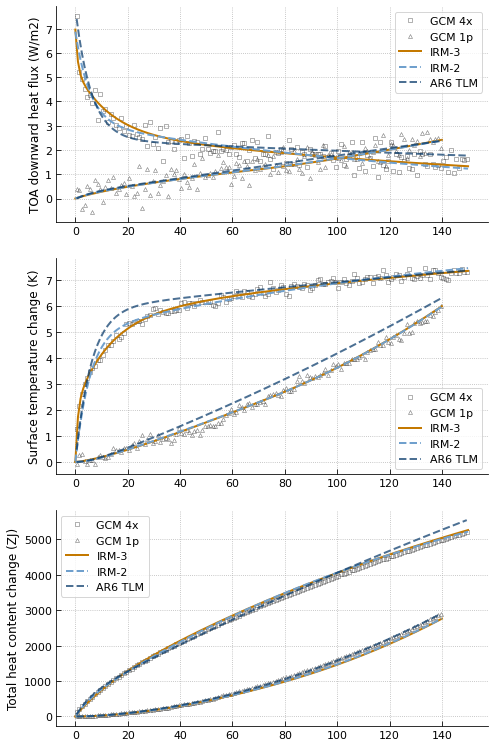

In [19]:
myplt.init_regular(
    3, kw_space={'height': 3., 'aspect': 2., 'hspace': 0.5},
)

kw_gcm = {
    'ls': 'None', 'mec': 'C0', 'mfc': 'none',
    'mew': 0.6, 'ms': 4, 'alpha': 0.5,
}
kw_irm2 = {'lw': 2., 'ls': '--', 'color': 'C1'}
kw_irm2e = {'lw': 2., 'ls': '--', 'color': 'C4', 'alpha': 0.7}
kw_irm3 = {'lw': 2., 'color': 'C2'}

map_label = {
    'rtnt': 'TOA downward heat flux (W/m2)',
    'tas': 'Surface temperature change (K)',
    'thc': 'Total heat content change (ZJ)',
}

for n, vn in enumerate(['rtnt', 'tas', 'thc']):
    ax = myplt(n)

    d1 = df_4x_gcm[vn]
    ax.plot(d1.index, d1, label='GCM 4x', marker='s', **kw_gcm)
    d1 = df_1p_gcm[vn]
    ax.plot(d1.index, d1, label='GCM 1p', marker='^', **kw_gcm)

    d1 = df_irm3_4x[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_irm2_4x[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)
    d1 = df_irm2e_4x[vn]
    ax.plot(d1.index, d1, label='AR6 TLM', **kw_irm2e)

    ax.legend()

    d1 = df_irm3_1p[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_irm2_1p[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)
    d1 = df_irm2e_1p[vn]
    ax.plot(d1.index, d1, label='AR6 TLM', **kw_irm2e)

    ax.set_ylabel(map_label[vn])
    ax.grid()

## Responses to a series of multiple pulses

Based on Gupta and Marshall (2018, https://doi.org/10.1175/JCLI-D-17-0703.1) regarding multiple volcanic eruptions

Relative large differences are found between two-layer and three-layer models

In [20]:
time = np.arange(60).astype('d')
erf1 = -1.
duration = 1
interval = 10

config = {'climate': {'nl': 2}} # two-layer
drv = Driver4x(**{**config, **parms_set['l2_norm1']})
df_2l = drv.get_pulse_response(time, erf1, duration, interval)
df_2l_peak = drv.get_pulse_peak(time, erf1, duration, interval)

drv = Driver4x(**{**config, **parms_set['l2e_ar6']})
df_2le = drv.get_pulse_response(time, erf1, duration, interval)
df_2le_peak = drv.get_pulse_peak(time, erf1, duration, interval)

config = {'climate': {'nl': 3}} # three-layer (default)
drv = Driver4x(**{**config, **parms_set['l3_norm1']})
df_3l = drv.get_pulse_response(time, erf1, duration, interval)
df_3l_peak = drv.get_pulse_peak(time, erf1, duration, interval)

In [21]:
(
    np.allclose(df_2l_peak, df_2l.loc[df_2l_peak.index, df_2l_peak.columns]),
    np.allclose(df_2le_peak, df_2le.loc[df_2le_peak.index, df_2le_peak.columns]),
    np.allclose(df_3l_peak, df_3l.loc[df_3l_peak.index, df_3l_peak.columns]),
)

(True, True, True)

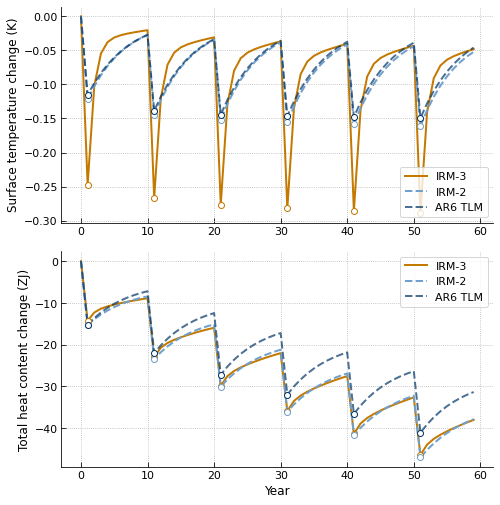

In [22]:
myplt.init_regular(2, kw_space={'aspect': 2., 'hspace': 0.4})

kw_marker = {'ls': 'None', 'marker': 'o', 'mfc': 'w'}

for n, vn in enumerate(['tas', 'thc']):
    ax = myplt(n)

    d1 = df_3l[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_2l[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)
    d1 = df_2le[vn]
    ax.plot(d1.index, d1, label='AR6 TLM', **kw_irm2e)

    ax.legend()

    d1 = df_3l_peak[vn]
    ax.plot(d1.index, d1, mec=kw_irm3['color'], **kw_marker)
    d1 = df_2l_peak[vn]
    ax.plot(d1.index, d1, mec=kw_irm2['color'], **kw_marker)
    d1 = df_2le_peak[vn]
    ax.plot(d1.index, d1, mec=kw_irm2e['color'], **kw_marker)

    if n == 1:
        ax.set_xlabel('Year')

    ax.set_ylabel(map_label[vn])
    ax.grid()